<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 21: Model Iteration and Improvement

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Practical Considerations When Applying Machine Learning

Suppose you trained an image classifier with 80% accuracy. What's next?

* Add more data?
* Train the algorithm for longer?
* Use a bigger model?
* Add regularization?
* Add new features?

We will next learn how to prioritize these decisions when applying ML.

# Fast & Data-Driven Model Iteration

The key to building great ML systems is to be *data-driven*:
* First, establish train, dev, and test sets and performance metrics.
* Then, build a quick prototype and look at its performance.
* Quickly iterate on the model, fixing the *actual errors* you see.

This process can compensate for an initial lack of domain expertise.

# Part 1: Error Analysis

A crucial part of understanding model performance is to systematically examine its errors.

Error analysis is a formal process by which this can be done.

# Review: Model Development Workflow

The machine learning development workflow has three steps:
1. __Training:__ Try a new model and fit it on the training set.

2. __Model Selection__: Estimate performance on the development set using metrics. Based on results, try a new model idea in step #1.

3. __Evaluation__: Finally, estimate real-world performance on test set.

# Review: Datasets for Model Development

When developing machine learning models, it is customary to work with three datasets:
* __Training set__: Data on which we train the models.
* __Development set__ (validation or hold-out set): Data used for tuning models.
* __Test set__: Data for evaluating the final performance of our model.

# How to Analyze Models

How do we iterate on a model given its results on the develoment set?

* Error analysis (this presentation)
* Analyzing overfitting and underfitting (later)
* Analyzing distributional changes (next lecture)

And many more types of analyses!

# Prioritizng Model Improvements: An Example

Suppose you trained an image classifier over animal photos.
* You hear anecdotes that some dogs are misclassified as cats.
* You have the option to integrate with a commercial dog classifier, which will take a month to implement.
* Should you move forward with the integration?

The key to this decision is to closely examine *actual performance*.

Suppose you need to decide if it's worth fixing a certain type of error.

* First, collect ~100 random dev set examples that were *misclassified*.
* Look at these examples, and count how many have that error.

If 5% of misclassified examples have that problem, it's probably not important. If 50% do, then it's important.

# Error Analysis

Error analysis systematically identifies the most common errors made by the model.

1. Collect a random subset of misclassified dev set examples.
2. Manually examine them; identify the most common types or *categories* of errors.
3. Count \% of points affected by each error categories.

You should prioritize the most common error categories.

# Error Categories

Error analysis involves classifying errors into *categories*.
* A category is a systematic error made by the model.
* Categories can come from intuition, but ideally they are constructed by manually examining the data.

# Error Analysis: An Example

Suppose you just trained a new image classifier.
* After looking at the first 20-30 errors, you realize they are all due to images being either *blurry*, *flipped*, or *mislabeled*.
* These become the error categories.

We then go through through the random subset of errors and assign them to categories.

$ $     | Blurry | Flipped | Mislabeled
--------|--------|---------|-----------
Image 1 | X      | X       |        
Image 2 |        | X       |       
Image 3 |        |         | X      
...     |        |         |       
__Total__   | 20%    | 50%     | 30%

We know that the most important fix is to correct for flipped images.

# Mislabeled Data

Real-world data is often messy, and labels are not always correct.
* __Scenario 1__: 10% error, of which 0.4% is due to labeling and 9.6% to other causes. No need to relabel.
* __Scenario 2__: 2% error, of which 0.4% is due to labeling and 1.6% to other causes. Important to relabel!
* These errors can be identified as part of error analysis
* The prevalence of these errors tells us if we should fix them

It's important to fix labeling issues if they prevent us from measuring model error.

# Development Set Size

How big should the dev set size be? Error analysis suggests a lower bound.
* You should have at least ~50-100 mislabeled errors to analyze.
* If model has error of $\epsilon$, we want a dev size of ~$100/\epsilon$.
    * e.g., for 5% error, we want a dev set of size ~2,000.

Also, remember to periodically update the dev set to minimize overfitting.

# Error Analysis on the Training Set

Should we perform error analysis on the dev set or the training set?

* Ultimately, we are interested in errors that will occur in production. This is best estimated on the dev set.

* However, if a model makes errors on the training set, it will make them on the dev set as well. 

Hence, analyzing and fixing training set errors is also important.

# Error Analysis: Another Example

Let's look at another example of error analysis on a small toy dataset.

We will use the `sklearn` digits dataset, a downscaled version of MNIST.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

We can visualize these digits as follows:

<Figure size 576x1152 with 0 Axes>

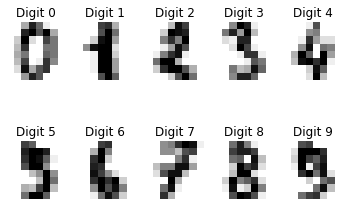

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,16))
_, axes = plt.subplots(2, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes.flatten(), images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Digit %i' % label)

Let's separate this data into two equal-sized training and dev sets.

In [4]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html
from sklearn.model_selection import train_test_split

# Split data into train and test subsets
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
X_train, X_dev, y_train, y_dev = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

We can train a simple Softmax model on this data.

In [5]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=1e7)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_dev)

It achieves the following accuracy.

In [6]:
(predicted == y_dev).mean()

0.9332591768631813

We hypothesize that certain digits are misclassified more than others.

(array([ 3., 11.,  2., 14.,  7.,  4.,  1.,  4.,  9.,  5.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

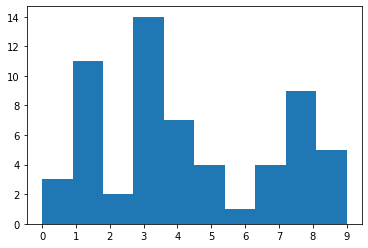

In [7]:
# these dev set digits are classified incorrectly
X_error = X_dev[predicted != y_dev]
y_error = y_dev[predicted != y_dev]
p_error = predicted[predicted != y_dev]

# these dev set digits are classified correctly
X_corr = X_dev[predicted == y_dev]
y_corr = y_dev[predicted == y_dev]
p_corr = predicted[predicted == y_dev]

# show the histogram
plt.xticks(range(10))
plt.hist(y_error)

The most common misclassified digit is a 3.

We can investigate the issue by looking at a subset of misclassified 3's (top row) and compare them to correctly classified 3's (bottom row).

<Figure size 576x1152 with 0 Axes>

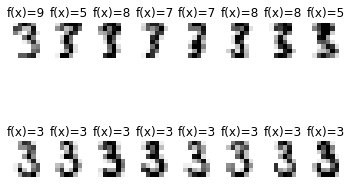

In [13]:
plt.figure(figsize=(8,16))
_, axes = plt.subplots(2, 8)

# these images are classified incorrectly
images_and_labels = list(zip(X_error[y_error==3], p_error[y_error==3]))
for ax, (image, label) in zip(axes[0,:], images_and_labels[:8]):
    ax.set_axis_off()
    ax.imshow(image.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('f(x)=%i' % label)

# these images are classified correctly
images_and_labels = list(zip(X_corr[y_corr==3], p_corr[y_corr==3]))    
for ax, (image, label) in zip(axes[1,:], images_and_labels[:8]):
    ax.set_axis_off()
    ax.imshow(image.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('f(x)=%i' % label) 

We discover that the model is misclassifying a particular stlye of 3, and we can focus our efforts on this type of error.

# Limitations of Error Analysis

The main limitations of error analysis include:
1. It is particularly easy to overfit the dev set, since we prioritize fixing dev set errors.
2. It can be laborious (but still important!)
3. Certain bigger trends (e.g. overfitting the data) may be less obvious.

Hence, we perform other analyses to explain and diagnose errors.

<left><img width=25% src="img/cornell_tech2.svg"></left>

# Part 2: Bias/Variance Analysis

Another way to understand the performance of the model is to examine the extent to which it's overfitting or underfitting the data. 

We refer to this as bias/variance analysis.

# Review: Error Analysis

Error analysis systematically identifies the most common errors made by the model.

1. Collect a random subset of misclassified dev set examples.
2. Manually examine them; identify the most common types or *categories* of errors.
3. Count \% of points affected by each error categories.

You should prioritize the most common error categories.

# Review: Overfitting (Variance)

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset, and doesn't generalize.

Recall this example, where we randomly sample around a true function.

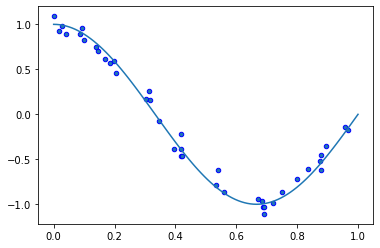

In [108]:
import numpy as np
np.random.seed(1)
n_samples = 40
true_fn = lambda X: np.cos(1.5 * np.pi * X)

X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1

X_line = np.linspace(0, 1, 100)
plt.plot(X_line, true_fn(X_line), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

Below, we fit a high degree polynomial on random samples of 30 points from this dataset.

Each small subset of the data that we train on results is a very different model.

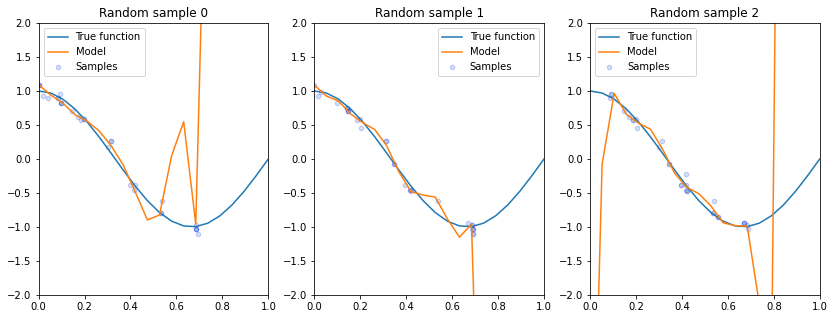

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

n_plots, X_line = 3, np.linspace(0,1,20)
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, 30, size=(30,))
    X_random, y_random = X[random_idx], y[random_idx]

    polynomial_features = PolynomialFeatures(degree= z, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_random[:, np.newaxis], y_random)

    ax.plot(X_line, true_fn(X_line), label="True function")    
    ax.plot(X_line, pipeline.predict(X_line[:, np.newaxis]), label="Model")
    ax.scatter(X_random, y_random, edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title('Random sample %d' % i)

An algorithm that has a tendency to overfit is also called __high variance__, because it outputs a predictive model that varies a lot if we slightly perturb the dataset.

# Review: Underfitting (Bias)

Underfitting is another common problem in machine learning.
* The model is too simple to fit the data well (e.g., approximating a high degree polynomial with linear regression).
* As a result, the model is not accurate on training data and is not accurate on new data.

Because the model cannot fit the data, we say it's __high bias__.

We may compare overfitting vs underfitting on our polynomial dataset.

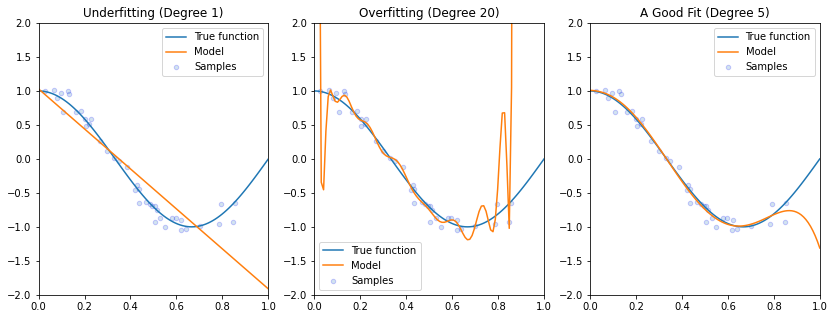

In [73]:
degrees = [1, 20, 5]
titles = ['Underfitting', 'Overfitting', 'A Good Fit']
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("{} (Degree {})".format(titles[i], degrees[i]))

# On the Signficance of Bias and Variance

Every error in machine learning is either underfitting (bias) or overfitting (variance).
* __Bias__: Our model is not able to extract signal from data.
* __Variance__: The signal doesn't generalize to new data.

By definition, if we have no bias and variance, we have a perfect model. Hence, bias/variance is important to understand.

# Quantifying Bias and Variance

We approximately quantify the bias and the variance of a model as follows.

$$\text{dev error} = (\underbrace{\text{dev error} - \text{train error}}_\text{variance}) + \underbrace{\text{train error}}_\text{bias}$$

* The bias is simply the training error (can we even fit training data?)

* Variance is the extra error on the dev set (do we generalize to it?)

It's important to consider both types of errors.
* If a model has high training error, it will certainly have high generalization error.
* As we fix training error, we need to ensure that it generalizes to new data.

We can make different changes to the algorithm to address both of these issues.

# Diagnosing Bias and Variance

We may use this observation to diagnose bias/variance in practice.
* If the training error is high, we have high bias.
* If dev error is much higher than training error, we have high variance.

Consider the following example:
* Our training set error is 15%.
* Our dev set error is 16%.
* Human error is 2%.

This is a typical example of __high bias__ (underfitting).

Next, consider another example:
* Our training set error is 4%.
* Our dev set error is 12%.
* Human error is 2%.

This is an example of __high variance__ (overfitting).

Finally, suppose you see the following:
* Our training set error is 2.5%.
* Our dev set error is 3%.
* Human error is 2%.

This is a model that seems to work quite well!

# Addressing Variance

The best way to reduce variance is to __give the model more data__. 
* Overfitting occurs because we don't have enough data to fit an expressive model.
* Hence, we add data and the memorized solution is no longer good.

However, this may be not be feasible because of high costs for compute or data acquisition.

Alternative options for reducing variance include:
* __Add Regularization__: L2 regularization, dropout, early stopping (increases bias)
* __Drop or Change Features__: Ideally, drop irrelevant ones (needs manual analysis)
* __Reduce Model Size__: Decrease layer size, kernel complexity, etc. Regularization often works better.

# Addressing Bias

The best way to reduce bias is to __increase the expressivity of the model__. 
* e.g., add more neural net layers, decrease kernel bandwidth, increase polynomial degree.
* A bigger (more expressive) model will fit the data better.

However, this may be not be feasible because of high costs for compute.

Alternative options for reducing bias include:

* __Add or Change Features__: Often based on manual analysis.
* __Reduce Regularization__: Change dropout, train model longer (incrases variance).
* __Adjust Model Architecture__: e.g., switch to ConvNets for image classification, which are more parameter-efficient than fully-connected networks (can also improve variance)

For both bias and variance reduction, we can use error analysis to guide our changes, e.g.:
* To determine which features to add/remove.
* To determine which additional data to collect.

# Bias/Variance Analysis: An Example

Let's use our earlier example with the sklearn digits dataset to illustrate this approach.

Recall our digits dataset from earlier:

<Figure size 576x1152 with 0 Axes>

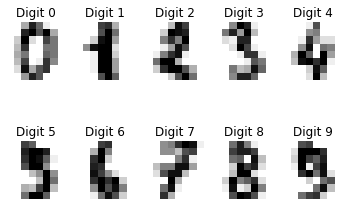

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,16))
_, axes = plt.subplots(2, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes.flatten(), images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Digit %i' % label)

We can train a small fully-connected neural network on this data.

In [52]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit:
predicted = classifier.predict(X_dev)
predicted_train = classifier.predict(X_train)

It achieves the following accuracy.

In [53]:
print('Training set accuracy: %.3f ' % (predicted_train == y_train).mean())
print('Development set accuracy: %.3f ' % (predicted == y_dev).mean())

Training set accuracy: 1.000 
Development set accuracy: 0.937 


We have clearly memorized our dataset, and are overfitting. Let's increase regularization.

In [103]:
classifier = MLPClassifier(max_iter=1000, alpha=1)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit:
predicted = classifier.predict(X_dev)
predicted_train = classifier.predict(X_train)

By increasing L2 regularization (`alpha`), we improve performance by 1%.
(Although we still somewhat overfit)

In [105]:
print('Training set accuracy: %.3f ' % (predicted_train == y_train).mean())
print('Development set accuracy: %.3f ' % (predicted == y_dev).mean())

Training set accuracy: 1.000 
Development set accuracy: 0.947 


# Error vs. Bias/Variance Analyses

These two analyses reveal different types of problems:
* __Systematic errors__ are found by error analysis (e.g., frequent errors on dog images because we lack training images of dogs)
* __General errors__ are found by bias/variance analysis (e.g., we memorized the training set and don't generalize)

These two analyses also complement each other.
* Bias/variance suggests which errors categories and which datasets (train, dev) are useful for error analysis.
* Error analysis identifies specific ways of fixing high bias or high variance (e.g., which new features to add)

# Bias/Variance Analysis vs Hyperparameter Search

Bias/variance analyses also helps guide hyperparameter search
* Hyperparamters are often chosen by grid or random search.
* Bias/variance analysis provides intuition for where to  search.
* For example, if we're overfitting, we need to search larger regularization values.

# Model Iteration Cycle

In summary, ML model development can be seen as alternating between the following two steps:
* __Reduce underfitting__ (e.g., increase model size)
* __Reduce overfitting__ (e.g., give it more data)

Error analysis guides specific changes in this process.

<left><img width=25% src="img/cornell_tech2.svg"></left>

# Part 3: Baselines

In order to understand model performance, we need to put it in context.

Baselines represent a benchmark against which we compare performance.

# Motivation

Suppose you train a regression model with a mean L1 error of 20.
* If we simply output the average $y$ on every input and this gives us an error of 20, then we haven't learned anything.
* In other cases, an error of 20 can be very good.

Thus, we need to put our results in context by comparing to other models.

# Baselines

A baseline is a another model against which we compare ourselves.
* These are often simple toy models that serve as a sanity check
* They also help us to interpret performance

Examples of baselines include:
* Random guessing, constant or average predictions.
* Simple models, such as interpretable trees or linear regression.
* Older, previous-generation ML models.
* Any classical approach that does not involve machine learning.

# Optimal Performance

In practice, we also want to set a target upper bound on our performance.
* The optimal error is often non-zero, e.g. even humans can't understand noisy speech.
* It tells us whether the model can be further improved.

# Estimating the Optimal Error Rate

There are different ways to compute an upper bound:
* Manually ask human annotators to label some data.
* Label data using crowdsourcing.
* Use the expected performance levels of downstream applications.

# Quantifying Bias Using Optimal Error

Our target optimal error helps us better quantify bias and variance:

$$\text{dev error} = (\underbrace{\text{dev error} - \text{train error}}_\text{variance}) + (\underbrace{\text{train error} - \text{opt error}}_\text{avoidable bias}) + \underbrace{\text{opt error}}_\text{unavoidable bias}$$

Consider the following example:
* Our training set error is 15%.
* Our dev set error is 20%.
* Ideal error is 14%.

The bias is almost ideal. We have a variance problem.

Next, consider this scenario:
* Our training set error is 5%.
* Our dev set error is 10%.
* Ideal error is 7%.

Training error is less than the ideal error! This means that we have overfit the training set. We have a variance problem.

Finally, consider another example:
* Our training set error is 8%.
* Our dev set error is 9%.
* Ideal error is 7%.

We are close to being optimal!